# **Task**
In the final project, you need to discover students’ common routines and
the pattern of happiness. You should propose a hypothesis by yourself
and validate it by using the data. To give you some examples, here are
some ideas.

- What is the relationship between the amount of discretionary time
(movie, gym, game) per day and happiness? Are they strictly correlated?
- What is the relationship between sleep schedule (length, regularity,
time) and happiness?
- Do people feel the same level of happiness in general?
- Do morning people feel more happiness than night people?
- What are the types of activities that most people enjoy or dislike?
- Do electronic devices (e.g., phone, tablets) involvement increase or
decrease happiness?

After you identify the topic, list the analysis that you need to perform
in order to get a solid conclusion. The analysis can include clustering,
decision tree, associate rule mining and data visualization.

# **Data Cleaning**
No matter what you propose to analyze, I suggest you to perform data
cleaning. When you look at the data, you probably can identify some tabs
with the same schedule everyday. Do you think this is true or just sloppy
data entry? Also, you probably can find similar activities with different
descriptions (e.g., watch drama, watch k drama, Netflix time). How do
you plan to deal with them

# **Import Libraries**

In [11]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.cluster import KMeans
import numpy as np


# **Data Consolidation**

In [ ]:
def read_full_student_schedule(file_path):
    sheet_names = pd.ExcelFile(file_path).sheet_names

    all_students_data = []

    for sheet_name in sheet_names:
        if '_' not in sheet_name or sheet_name[0] not in ['A', 'B', 'C']:
            continue

        try:
            df = pd.read_excel(file_path, sheet_name=sheet_name, header=4)

            if df.empty or df.shape[1] < 5:
                continue

        except Exception as e:
            continue

        student_id = str(sheet_name.split('_')[1])

        if sheet_name.startswith('A'):
            submission_week = 'Week1'
        elif sheet_name.startswith('B'):
            submission_week = 'Week2'
        elif sheet_name.startswith('C'):
            submission_week = 'Week3'
        else:
            submission_week = 'Unknown'

        days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

        for i, day in enumerate(days):
            #start_col = 1 + i * 4  # Block starts from column 1
            # Adjusted to start from column 2 (0-indexed)
            start_col = 2 + i * 4   # block now starts from column 2

            if start_col + 3 >= len(df.columns):
                continue  # check bounds

            try:
                # Extracting the relevant columns               
                time_column = df.iloc[:, 1]            # Time (always 1st column)
                activity_column = df.iloc[:, start_col]       # Activity
                who_column = df.iloc[:, start_col + 1]        # Who
                where_column = df.iloc[:, start_col + 2]      # Where
                happy_column = df.iloc[:, start_col + 3]      # Happy (rating)

                temp_df = pd.DataFrame({
                    'Student_ID': student_id,
                    'Day': day,
                    'Submission_Week': submission_week,
                    'Time': time_column,
                    'Activity': activity_column,
                    'Who': who_column,
                    'Where': where_column,
                    'Happy': happy_column
                })

                all_students_data.append(temp_df)

            except Exception as e:
                continue

    if all_students_data:
        master_df = pd.concat(all_students_data, ignore_index=True)

        # ✨ Forward fill for merged cells
        master_df['Activity'] = master_df['Activity'].ffill()
        master_df['Who'] = master_df['Who'].ffill()
        master_df['Where'] = master_df['Where'].ffill()

        # Make sure Happy is numeric
        master_df['Happy'] = pd.to_numeric(master_df['Happy'], errors='coerce')

        return master_df
    else:
        return pd.DataFrame()


In [51]:
file_path = './all_data.xlsx'

# Read the full student schedule
master_df = read_full_student_schedule(file_path)

#save to csv
master_df.to_csv('master_student_schedules.csv', index=False)

In [14]:
master_df.head(100)

,Student_ID,Day,Submission_Week,Time,Activity,Who,Where,Happy
0,4195058507542523904,Monday,Week1,00:00:00,Sleep,Self,Home,NaN
1,4195058507542523904,Monday,Week1,00:30:00,Sleep,Self,Home,NaN
2,4195058507542523904,Monday,Week1,01:00:00,Sleep,Self,Home,NaN
3,4195058507542523904,Monday,Week1,01:30:00,Sleep,Self,Home,NaN
4,4195058507542523904,Monday,Week1,02:00:00,Sleep,Self,Home,NaN
...,...,...,...,...,...,...,...,...
95,4195058507542523904,Tuesday,Week1,23:30:00,Sleep,Self,Home,NaN
96,4195058507542523904,Wednesday,Week1,00:00:00,Sleep,Self,Home,NaN
97,4195058507542523904,Wednesday,Week1,00:30:00,Sleep,Self,Home,NaN
98,4195058507542523904,Wednesday,Week1,01:00:00,Sleep,Self,Home,NaN


#  **Data Preprocessing and Cleaning**

In [15]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68251 entries, 0 to 68250
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Student_ID       68251 non-null  object 
 1   Day              68251 non-null  object 
 2   Submission_Week  68251 non-null  object 
 3   Time             67607 non-null  object 
 4   Activity         68251 non-null  object 
 5   Who              68251 non-null  object 
 6   Where            68251 non-null  object 
 7   Happy            32579 non-null  float64
dtypes: float64(1), object(7)
memory usage: 4.2+ MB


**Check Missing Values**

In [16]:
print(master_df.isnull().sum())

Student_ID             0
Day                    0
Submission_Week        0
Time                 644
Activity               0
Who                    0
Where                  0
Happy              35672
dtype: int64


**Handling Missing Happiness Ratings**

In [17]:
# Forward fill for missing happiness
master_df['Happy'] = master_df['Happy'].ffill()


# Fill missing Happy ratings with the student's mean and round it to nearest whole number
master_df['Happy'] = (
    master_df.groupby('Student_ID')['Happy']
    .transform(lambda x: x.fillna(x.mean()))
    .round(0)  # round to nearest integer
    .astype('Int64')  # keep it as integer (but allow missing values if needed)
)



**Cleaning and Standardizing Activity Names**

In [18]:

# Define activity categories
activity_mapping = {
    # Sleep-related
    'sleep': 'Sleep',
    'nap': 'Sleep',
    'going to bed': 'Sleep',
    'wake up': 'Sleep',
    'power nap': 'Sleep',
    'prepare to sleep': 'Sleep',
    'get ready for bed': 'Sleep',
    'woke up': 'Sleep',
    'fresh up': 'Sleep',
    'wake-up': 'Sleep',
    'waking up': 'Sleep',

    # Study / Homework
    'study': 'Academics',
    'homework': 'Academics',
    'assignment': 'Academics',
    'class': 'Academics',
    'lecture': 'Academics',
    'research': 'Academics',
    'project': 'Academics',
    'learn': 'Academics',
    'reading': 'Academics',
    'preparing for class': 'Academics',
    'assignments': 'Academics',
    'working on projects': 'Academics',
    'attending class': 'Academics',
    'online class': 'Academics',
    'online lecture': 'Academics',
    'studying': 'Academics',
    'preparing for exam': 'Academics',
    'preparing for test': 'Academics',
    'preparing for assignment': 'Academics',
    'preparing for project': 'Academics',
    'preparing for lecture': 'Academics',
    'preparing for research': 'Academics',
    'preparing for study': 'Academics',
    'preparing for classwork': 'Academics',
    'preparing for course': 'Academics',
    'coding': 'Academics',
    'preparing for exams': 'Academics',
    'searched for certification courses': 'Academics',
    'searched for online courses': 'Academics',
    'read': 'Academics',
    'School': 'Academics',
    'College': 'Academics',
    'Journaling': 'Academics',
    'ACADEMICS': 'Academics',
    'Academics': 'Academics',
    'DSA ': 'Academics',
    'PORTFOLIO': 'Academics',
    'LEETCODE': 'Academics',
    'LINKEDIN REVIEW': 'Academics',
    'sought for certification courses': 'Academics',
    'preparing for interviews': 'Academics',
    'tutoring': 'Academics',
    'learning python': 'Academics',
    'learning sql': 'Academics',
    'learning data science': 'Academics',
    'learning algorithms': 'Academics',
    'learning skills on stock market': 'Academics',
    'working on assignments': 'Academics',
    'planning': 'Academics',
    'organizing': 'Academics',
    

    # Exercise / Gym
    'exercise': 'Exercise / Gym',
    'workout': 'Exercise / Gym',
    'gym': 'Exercise / Gym',
    'yoga': 'Exercise / Gym',
    'badminton': 'Exercise / Gym',
    'soccer': 'Exercise / Gym',
    'going to the gym': 'Exercise / Gym',
    'morning walk': 'Exercise / Gym',
    'walking': 'Exercise / Gym',
    'running': 'Exercise / Gym',
    'light workout': 'Exercise / Gym',
    'stretching': 'Exercise / Gym',
    'jogging': 'Exercise / Gym',
    'playing sports': 'Exercise / Gym',
    'playing games': 'Exercise / Gym',
    'playing throwball': 'Exercise / Gym',
    'playing badminton': 'Exercise / Gym',

    # Eating / Meals
    'breakfast': 'Eating / Meals',
    'lunch': 'Eating / Meals',
    'dinner': 'Eating / Meals',
    'snack': 'Eating / Meals',
    'coffee': 'Eating / Meals',
    'tea': 'Eating / Meals',
    'brunch': 'Eating / Meals',
    'supper': 'Eating / Meals',
    'preparing lunch': 'Eating / Meals',
    'preparing dinner': 'Eating / Meals',
    'cooking': 'Eating / Meals',
    'making breakfast': 'Eating / Meals',
    'making lunch': 'Eating / Meals',
    'making dinner': 'Eating / Meals',
    'eating together': 'Eating / Meals',
    'eating': 'Eating / Mealsd',
    'meal prep': 'Eating / Meals',
    'cooking food': 'Eating / Meals',
    'cooking and having dinner': 'Eating / Meals',
    'cooking and having lunch': 'Eating / Meals',
    'cooking and having breakfast': 'Eating / Meals',
    'prepared fruit juice': 'Eating / Meals',
    'prepared smoothie': 'Eating / Meals',
    'making chicken pakodi and curry': 'Eating / Meals',
    'Making chicken curry': 'Eating / Meals',
    'eat': 'Eating / Meals',
    'Pizza NYC': 'Eating / Meals',
    'Break': 'Eating / Meals',
    'Eating': 'Eating / Meals',
    'Had brekfast  ': 'Eating / Meals',
    'Had lunch': 'Eating / Meals',
    'cooked food': 'Eating / Meals',
    'preparing food': 'Eating / Meals',
    'preparing breakfast': 'Eating / Meals',
    'eating breakfast': 'Eating / Meals',
    'eating lunch': 'Eating / Meals',
    'eating dinner': 'Eating / Meals',
    'buying groceries': 'Eating / Meals',
    'having pizza': 'Eating / Meals',
    'having drinks': 'Eating / Meals',
    'having dessert': 'Eating / Meals',
    'having smoothie': 'Eating / Meals',


    # Socializing / Hanging Out
    'hanging out with friends': 'Socializing',
    'hanging out': 'Socializing',
    'meeting friends': 'Socializing',
    'party': 'Socializing',
    'celebration': 'Socializing',
    'chilling with friends': 'Socializing',
    'talking to friends': 'Socializing',
    'call': 'Socializing',
    'talking to family': 'Socializing',
    'spending time with family': 'Socializing',
    'going out with friends': 'Socializing',
    'video call with family': 'Socializing',
    'chatting with friends': 'Socializing',
    'video calling': 'Socializing',
    'video call with friends': 'Socializing',
    'Indoor with friends': 'Socializing',
    'Indoor with family': 'Socializing',
    'Indoor with relatives': 'Socializing',
    'Spending time with roommates': 'Socializing',
    'Spending time with family': 'Socializing',
    'Talking to parents': 'Socializing',
    'Talking to family': 'Socializing',
    'Talking to friends': 'Socializing',
    'Talking to relatives': 'Socializing',
    'talking to brother on phone': 'Socializing',
    'talking to sister on phone': 'Socializing',
    'talking to parents on phone': 'Socializing',
    'talking to family on phone': 'Socializing',
    'went to meet a friend': 'Socializing',
    'Family time': 'Socializing',
    'indoor with friends': 'Socializing',
    'spending time with roommate': 'Socializing',
    'went out with friends': 'Socializing',
    'talking to parents': 'Socializing',
    'talking to sister': 'Socializing',
    'talking with family': 'Socializing',
    'chit-chat with friends': 'Socializing',
    'family time': 'Socializing',
    'spending time with grandma': 'Socializing',
    'visiting relatives house': 'Socializing',
    'going out for a walk': 'Socializing',
    'going to the park': 'Socializing',
    'going to NYC': 'Socializing',
    'going to the mall': 'Socializing',
    'going to the restaurant': 'Socializing',
    'going to the movies': 'Socializing',
    'going to the beach': 'Socializing',
    'going to the library': 'Socializing',
    'going to the salon': 'Socializing',
    'going to the bar': 'Socializing',
    'going to the cafe': 'Socializing',
    'going to the event': 'Socializing',
    'going to the concert': 'Socializing',
    'going to the party': 'Socializing',
    'going to the function': 'Socializing',
    'going to the wedding': 'Socializing',
    'going to the birthday party': 'Socializing',
    'going to the family gathering': 'Socializing',
    'engaged with phone': 'Socializing',
    'chatting with family': 'Socializing',

    # Entertainment / Leisure
    'watching': 'Entertainment',
    'watching youtube': 'Entertainment',
    'watching series': 'Entertainment',
    'watching webseries': 'Entertainment',
    'watching tv': 'Entertainment',
    'watching show': 'Entertainment',
    'watching anime': 'Entertainment',
    'watching movie with friends': 'Entertainment',
    'watch netflix': 'Entertainment',
    'watching movie': 'Entertainment',
    'movie': 'Entertainment',
    'youtube': 'Entertainment',
    'tv': 'Entertainment',
    'gaming': 'Entertainment',
    'series': 'Entertainment',
    'webseries': 'Entertainment',
    'binge-watching': 'Entertainment',
    'listening to music': 'Entertainment',
    'Played Show': 'Entertainment',
    'Went out to play in snow': 'Entertainment',
    'Played with friends': 'Entertainment',
    'Video games': 'Entertainment',
    'Playing games': 'Entertainment',
    'netflix': 'Entertainment',
    'watching movies': 'Entertainment',
    'playing video games': 'Entertainment',
    'going to the theater': 'Entertainment',


    # Travel / Commute
    'drive': 'Travel / Commute',
    'commute': 'Travel / Commute',
    'travel': 'Travel / Commute',
    'path': 'Travel / Commute',
    'train': 'Travel / Commute',
    'bus': 'Travel / Commute',
    'Getting ready for University': 'Travel / Commute',
    'Getting ready for college': 'Travel / Commute',
    'Travlling to University': 'Travel / Commute',
    'Returning to home': 'Travel / Commute',
    'Travelling to home': 'Travel / Commute',
    'Go to school': 'Travel / Commute',
    'Go to college': 'Travel / Commute',
    'Go to university': 'Travel / Commute',
    'Go home': 'Travel / Commute',
    'Car Driving Practice': 'Travel / Commute',
    'Getting Read To The University': 'Travel / Commute',
    'Getting ready for university': 'Travel / Commute',
    'Driving': 'Travel / Commute',
    'Driving to university': 'Travel / Commute',
    'Driving to college': 'Travel / Commute',
    'Driving to home': 'Travel / Commute',
    'Driving to school': 'Travel / Commute',
    'Driving to work': 'Travel / Commute',
    'Getting Ready for College': 'Travel / Commute',
    'went to pick up a friend': 'Travel / Commute',
    'went to pick up groceries': 'Travel / Commute',
    'FLIGHT TO NEW HAVEN': 'Travel / Commute',
    'travelling to university': 'Travel / Commute',
    'returning to home': 'Travel / Commute',
    'going to school': 'Travel / Commute',
    'commuting to home': 'Travel / Commute',
    'commuting for university': 'Travel / Commute',
    'driving to school': 'Travel / Commute',
    'driving home': 'Travel / Commute',
    'driving to work': 'Travel / Commute',
    'driving to the airport': 'Travel / Commute',
    'taking the train': 'Travel / Commute',
    'taking the bus': 'Travel / Commute',
    'walking to campus': 'Travel / Commute',
    'walking to class': 'Travel / Commute',
    'walking to the train station': 'Travel / Commute',
    'walking to the bus stop': 'Travel / Commute',
    'walking back home': 'Travel / Commute',


    # Phone / Social Media
    'using phone': 'Phone / Social Media',
    'scroll': 'Phone / Social Media',
    'instagram': 'Phone / Social Media',
    'tiktok': 'Phone / Social Media',
    'phone call': 'Phone / Social Media',
    'video call': 'Phone / Social Media',
    'scrolling social media': 'Phone / Social Media',
    'social media browsing': 'Phone / Social Media',
    'scrolling': 'Phone / Social Media',
    'social media': 'Phone / Social Media',
    'Use phone': 'Phone / Social Media',
    'Using phone': 'Phone / Social Media',
    'Phone break': 'Phone / Social Media',
    'Phone time': 'Phone / Social Media',
    'Take care of self with phone': 'Phone / Social Media',
    'Using phone and relaxing': 'Phone / Social Media',
    'using mobile': 'Phone / Social Media',
    'phone break': 'Phone / Social Media',
    'phone time': 'Phone / Social Media',


    # Personal Care and Hygiene
    'selfcare': 'Personal Care',
    'haircut': 'Personal Care',
    'shower': 'Personal Care',
    'bath': 'Personal Care',
    'taking a bath': 'Personal Care',
    'skin care': 'Personal Care',
    'hair care': 'Personal Care',
    'facewash': 'Personal Care',
    'morning routine': 'Personal Care',
    'getting fresh up': 'Personal Care',
    'bathroom with phone': 'Personal Care',
    'washroom': 'Personal Care',
    'shower and skin care': 'Personal Care',
    'shower with music': 'Personal Care',
    'shower and get ready': 'Personal Care',
    'Self-improvement': 'Personal Care',
    'Self-care': 'Personal Care',
    'Freshening up': 'Personal Care',
    'SELF CARE': 'Personal Care',
    'self-improvement': 'Personal Care',
    'Self improvement': 'Personal Care',

    # Chores / Errands
    'chores': 'Chores / Errands',
    'laundry': 'Chores / Errands',
    'cleaning': 'Chores / Errands',
    'grocery': 'Chores / Errands',
    'shopping': 'Chores / Errands',
    'dishes': 'Chores / Errands',
    'room cleaning': 'Chores / Errands',
    'cleaning room': 'Chores / Errands',
    'cleaning house': 'Chores / Errands',
    'cleaning the house': 'Chores / Errands',
    'cleaning the room': 'Chores / Errands',
    'cleaning the kitchen': 'Chores / Errands',
    'cleaning the bathroom': 'Chores / Errands',
    'cleaning the washroom': 'Chores / Errands',
    'cleaning the floor': 'Chores / Errands',
    'cleaning the car': 'Chores / Errands',
    'cleaning the garden': 'Chores / Errands',
    'cleaning the garage': 'Chores / Errands',
    'Buying Groceries': 'Chores / Errands',
    'Apple Store': 'Chores / Errands',
    'Grocery shopping': 'Chores / Errands',
    'Wall st bull': 'Chores / Errands',
    'Wall street bull': 'Chores / Errands',
    'doing laundry': 'Chores / Errands',
    'doing dishes': 'Chores / Errands',
    'house chores': 'Chores / Errands',
    'house cleaning': 'Chores / Errands',
    'grocery shopping': 'Chores / Errands',
    'errands': 'Chores / Errands',
    

    # Religious / Spiritual
    'prayer': 'Religious / Spiritual',
    'temple': 'Religious / Spiritual',
    'church': 'Religious / Spiritual',
    'meditation': 'Religious / Spiritual',

    # Work / Internship
    'working': 'Work / Internship',
    'internship': 'Work / Internship',
    'job application': 'Work / Internship',
    'meeting': 'Work / Internship',
    'resume': 'Work / Internship',
    'job search': 'Work / Internship',
    'job interview': 'Work / Internship',
    'job hunting': 'Work / Internship',
    'job': 'Work / Internship',
    'work': 'Work / Internship',
    'office': 'Work / Internship',
    'office work': 'Work / Internship',
    'teaching': 'Work / Internship',
    'training': 'Work / Internship',
    'checking emails': 'Work / Internship',
    'checking messages': 'Work / Internship',
    'Schedule': 'Work / Internship',
    'checking work': 'Work / Internship',
    'checking tasks': 'Work / Internship',
    'To do': 'Work / Internship',
    'To do list': 'Work / Internship',
    'To do list checking': 'Work / Internship',
    'Checking mails and Handshake': 'Work / Internship',
    'Checking emails': 'Work / Internship',
    'Preparing for Interviews': 'Work / Internship',
    'Preparing for job interviews': 'Work / Internship',

    # Creative / Hobbies
    'music': 'Creative / Hobbies',
    'art': 'Creative / Hobbies',
    'dance': 'Creative / Hobbies',
    'guitar': 'Creative / Hobbies',
    'drawing': 'Creative / Hobbies',

    # Events / Outings
    'mall': 'Events / Outings',
    'park': 'Events / Outings',
    'restaurant': 'Events / Outings',
    'broadway': 'Events / Outings',
    'bar' : 'Events / Outings',
    'concert': 'Events / Outings',
    'Event': 'Events / Outings',
    'Going out': 'Events / Outings',

    # Health / Doctor
    'doctor': 'Health / Doctor',
    'physiotherapy': 'Health / Doctor',
    'hospital': 'Health / Doctor',
    
    # Relaxation
    'relax': 'Relaxation',
    'chill': 'Relaxation',
    'rest': 'Relaxation',
    'Walking': 'Relaxation',
    'Walk': 'Relaxation',
    'Relax': 'Relaxation',
    'Going out for a Walk': 'Relaxation',
    'Going out for walk': 'Relaxation',
    'Cuddle with my baby': 'Relaxation',
    'Cuddle with my baby and relax': 'Relaxation',
    'Feed my baby': 'Relaxation',
    'Playing time with my baby': 'Relaxation',
    'Play with my baby': 'Relaxation',
    'Went for a walk': 'Relaxation',
    'Went out for a walk': 'Relaxation',
    'quiet time': 'Relaxation',
    
    
}




In [19]:
# Mapping function
def map_activity(activity):
    if pd.isna(activity):
        return 'Unknown'
    
    activity = str(activity).lower().strip()

    # Check if any keyword is in the activity
    for keyword, category in activity_mapping.items():
        if keyword in activity:
            return category
    
    return 'Other'  # Default if not matched


In [20]:
# Apply mapping to the dataframe
master_df['Activity_Cleaned'] = master_df['Activity'].apply(map_activity)


master_df[['Activity', 'Activity_Cleaned']].head()

,Activity,Activity_Cleaned
0,Sleep,Sleep
1,Sleep,Sleep
2,Sleep,Sleep
3,Sleep,Sleep
4,Sleep,Sleep


**Cleaning and Standardizing Time Column**

In [21]:
# Read Time column as string first
master_df['Time'] = master_df['Time'].astype(str)

# Now try to convert again
master_df['Time'] = pd.to_datetime(master_df['Time'], errors='coerce')
master_df['Time'] = master_df['Time'].dt.time


C:\Users\tinot\AppData\Local\Temp\ipykernel_35756\7232066.py:5: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [52]:
master_df.head()


,Student_ID,Day,Submission_Week,Time,Activity,Who,Where,Happy
0,4195058507542523866,Monday,Week1,00:00:00,Sleep,Self,Home,NaN
1,4195058507542523866,Monday,Week1,00:30:00,Sleep,Self,Home,NaN
2,4195058507542523866,Monday,Week1,01:00:00,Sleep,Self,Home,NaN
3,4195058507542523866,Monday,Week1,01:30:00,Sleep,Self,Home,NaN
4,4195058507542523866,Monday,Week1,02:00:00,Sleep,Self,Home,NaN


In [23]:
master_df.to_csv('schedules_cleaned.csv', index=False)

# **New Cleaned Data Set**

In [24]:
import pandas as pd
cleaned_data = pd.read_csv('schedules_cleaned.csv')
cleaned_data.head()

,Student_ID,Day,Submission_Week,Time,Activity,Who,Where,Happy,Activity_Cleaned
0,4195058507542523904,Monday,Week1,00:00:00,Sleep,Self,Home,7,Sleep
1,4195058507542523904,Monday,Week1,00:30:00,Sleep,Self,Home,7,Sleep
2,4195058507542523904,Monday,Week1,01:00:00,Sleep,Self,Home,7,Sleep
3,4195058507542523904,Monday,Week1,01:30:00,Sleep,Self,Home,7,Sleep
4,4195058507542523904,Monday,Week1,02:00:00,Sleep,Self,Home,7,Sleep


In [25]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68251 entries, 0 to 68250
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Student_ID        68251 non-null  int64 
 1   Day               68251 non-null  object
 2   Submission_Week   68251 non-null  object
 3   Time              67425 non-null  object
 4   Activity          68251 non-null  object
 5   Who               68251 non-null  object
 6   Where             68251 non-null  object
 7   Happy             68251 non-null  int64 
 8   Activity_Cleaned  68251 non-null  object
dtypes: int64(2), object(7)
memory usage: 4.7+ MB


**Top 20 Most Common Activities**

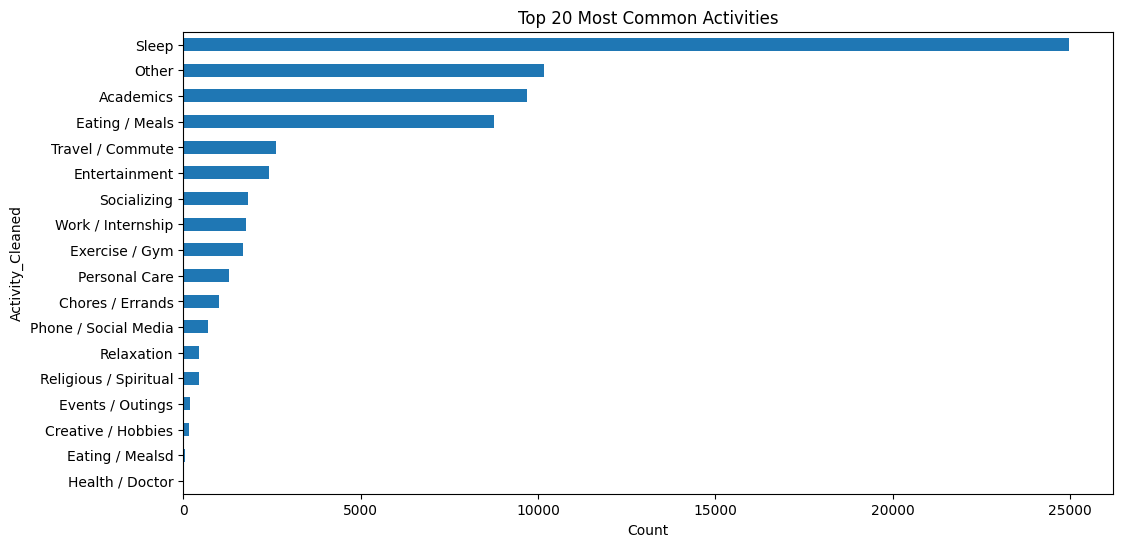

In [26]:
import matplotlib.pyplot as plt

top_activities = cleaned_data['Activity_Cleaned'].value_counts().head(20)

plt.figure(figsize=(12, 6))
top_activities.plot(kind='barh')
plt.title('Top 20 Most Common Activities')
plt.xlabel('Count')
plt.gca().invert_yaxis()
plt.show()


**Distribution of Happiness Scores**

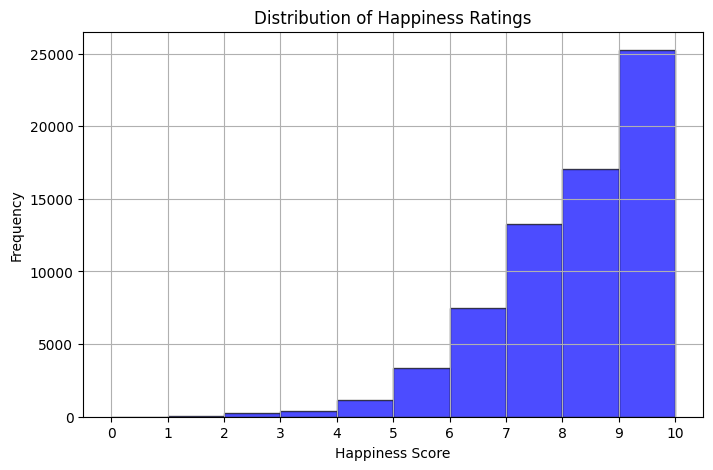

In [27]:
plt.figure(figsize=(8, 5))
cleaned_data['Happy'].hist(bins=[0,1,2,3,4,5,6,7,8,9,10], alpha=0.7, color='blue', edgecolor='black')
plt.xticks(range(0, 11))
plt.title('Distribution of Happiness Ratings')
plt.xlabel('Happiness Score')
plt.ylabel('Frequency')
plt.show()


**Average Happiness by Day**

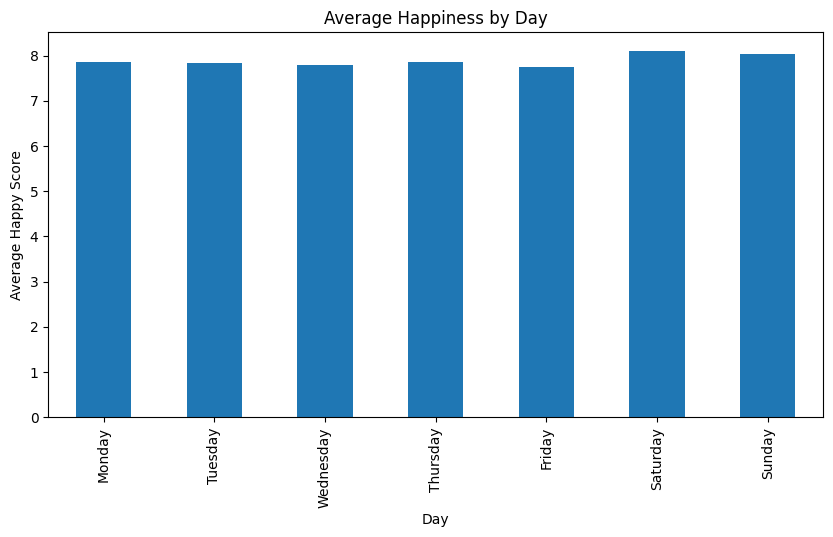

In [28]:
avg_happy_day = cleaned_data.groupby('Day')['Happy'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

plt.figure(figsize=(10, 5))
avg_happy_day.plot(kind='bar')
plt.title('Average Happiness by Day')
plt.ylabel('Average Happy Score')
plt.show()


**Most Popular Activities per Day (Heatmap)**

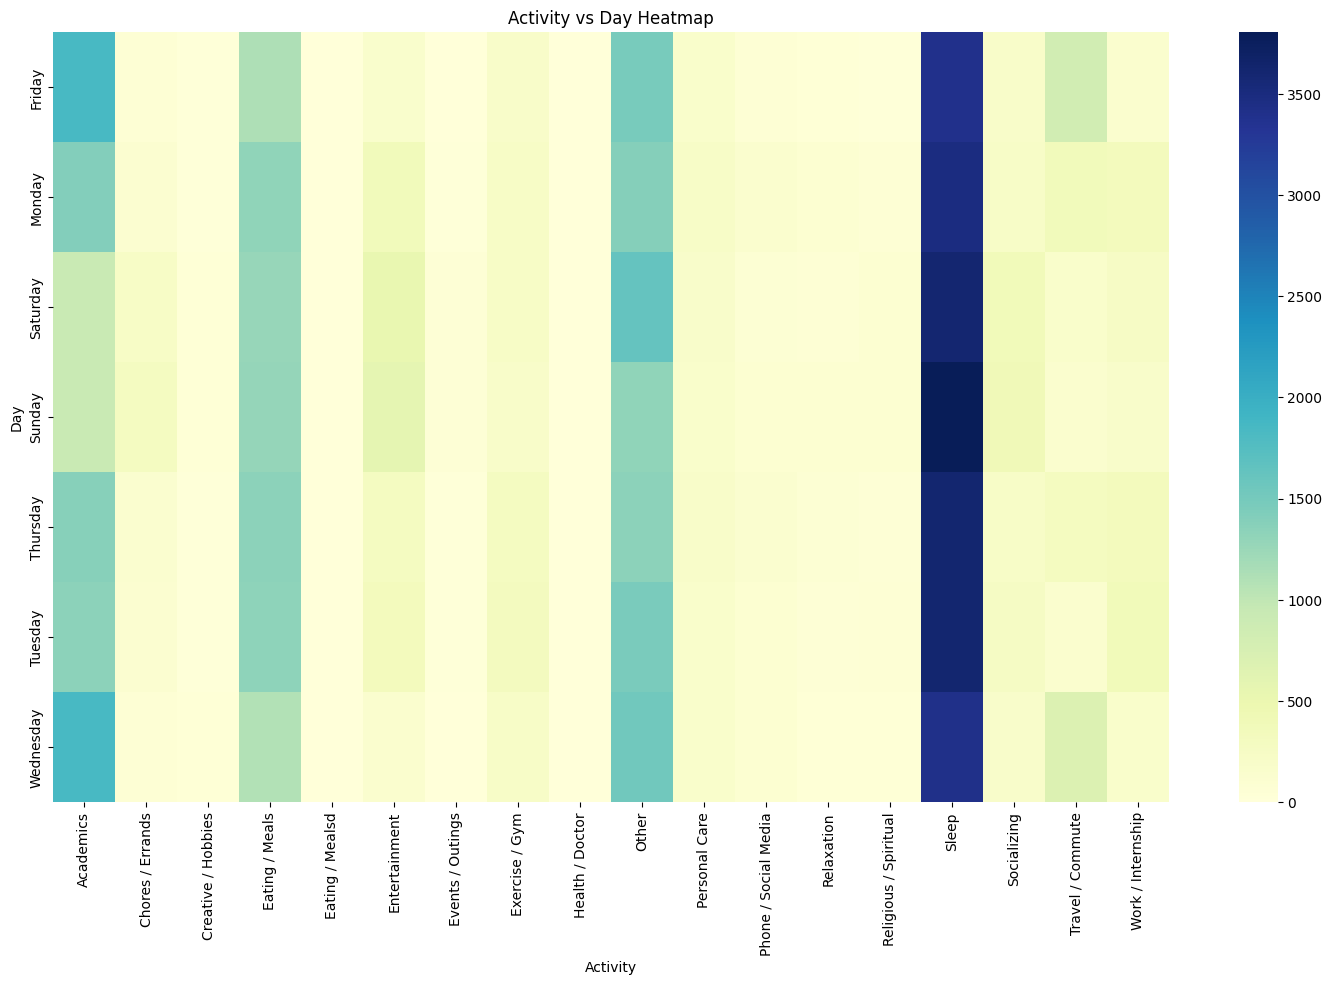

In [29]:
import seaborn as sns
activity_day = pd.crosstab(cleaned_data['Day'], cleaned_data['Activity_Cleaned'])

plt.figure(figsize=(18, 10))
sns.heatmap(activity_day, cmap="YlGnBu", cbar=True)
plt.title('Activity vs Day Heatmap')
plt.xlabel('Activity')
plt.ylabel('Day')
plt.show()


**Activity vs Average Happiness**

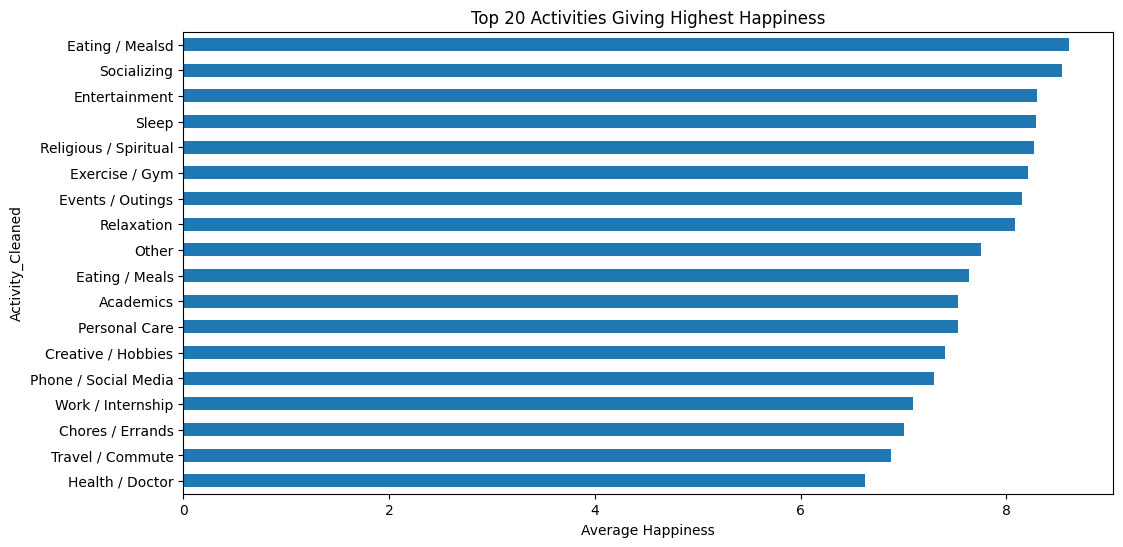

In [30]:
avg_happy_activity = cleaned_data.groupby('Activity_Cleaned')['Happy'].mean().sort_values(ascending=False).head(20)

plt.figure(figsize=(12, 6))
avg_happy_activity.plot(kind='barh')
plt.title('Top 20 Activities Giving Highest Happiness')
plt.xlabel('Average Happiness')
plt.gca().invert_yaxis()
plt.show()


**Time Distribution (Hourly)**

C:\Users\tinot\AppData\Local\Temp\ipykernel_35756\3705623714.py:1: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



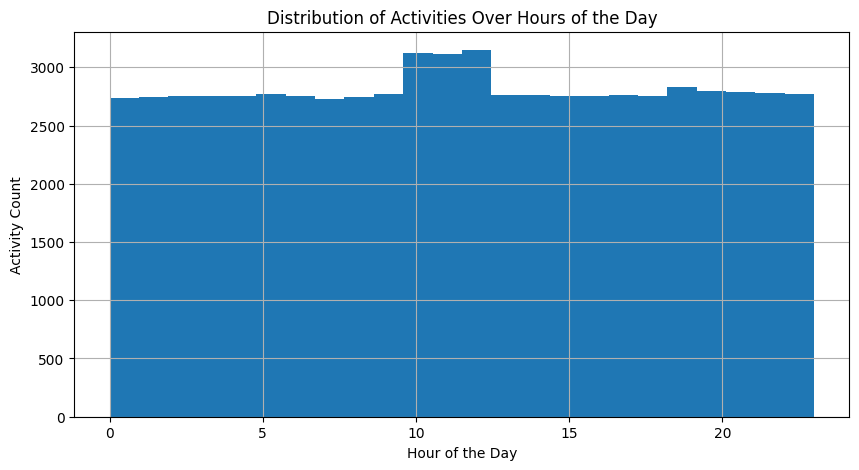

In [31]:
cleaned_data['Hour'] = pd.to_datetime(cleaned_data['Time'], errors='coerce').dt.hour

plt.figure(figsize=(10, 5))
cleaned_data['Hour'].hist(bins=24)
plt.title('Distribution of Activities Over Hours of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Activity Count')
plt.show()


**Happy Scores by Who (Self, Friends, Family)**

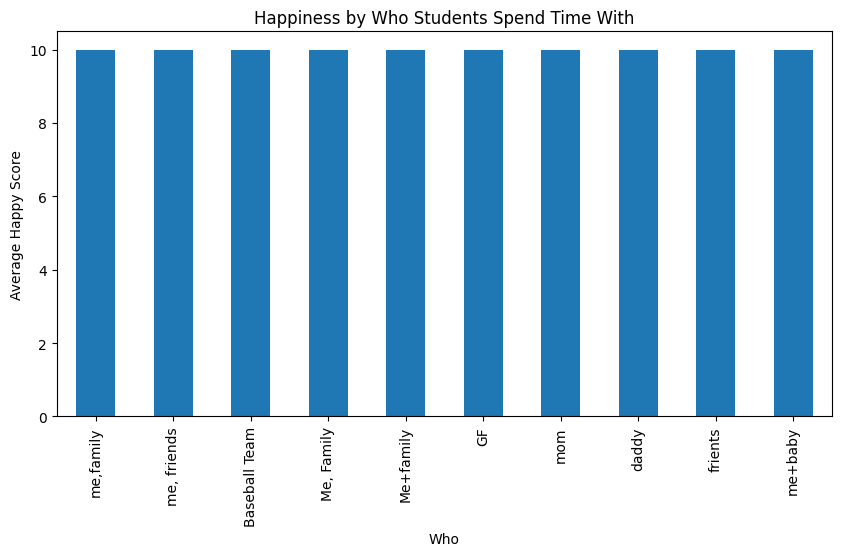

In [32]:
avg_happy_who = cleaned_data.groupby('Who')['Happy'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 5))
avg_happy_who.plot(kind='bar')
plt.title('Happiness by Who Students Spend Time With')
plt.ylabel('Average Happy Score')
plt.show()


**Activity Switch Heatmap**
Which activities students often switch between across different days.

Example: Sleep → Gym → Study → Social Media → Sleep

Prepare sequences of activities by day.

Create a transition matrix showing how often an activity leads to another

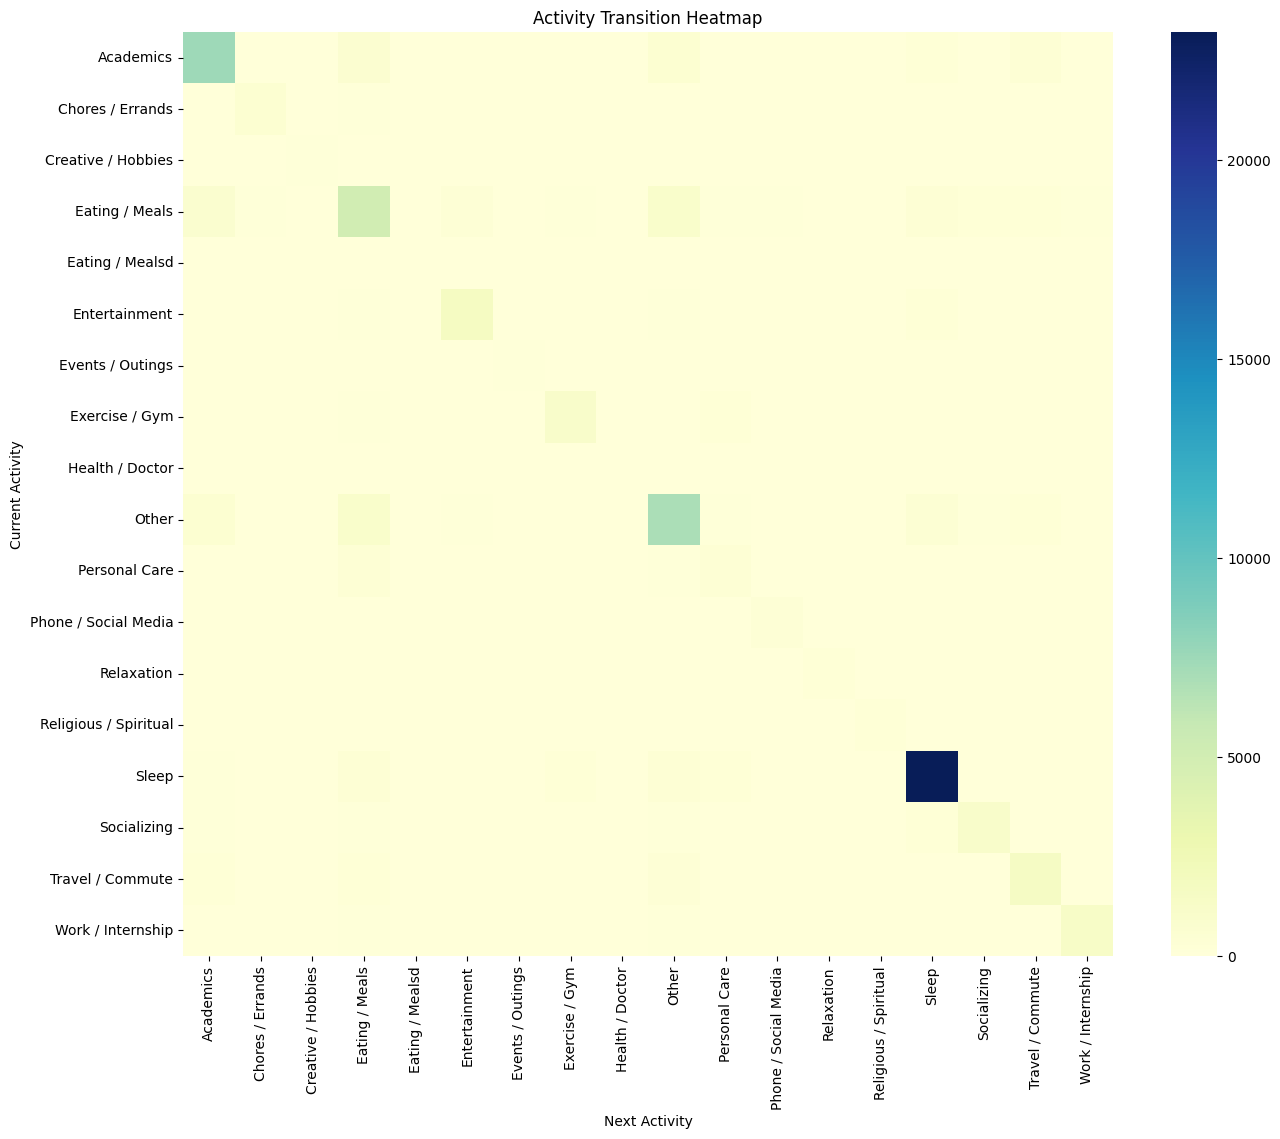

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a transition DataFrame
cleaned_data['Next_Activity'] = cleaned_data['Activity_Cleaned'].shift(-1)
transitions = cleaned_data.groupby(['Activity_Cleaned', 'Next_Activity']).size().unstack(fill_value=0)

plt.figure(figsize=(15, 12))
sns.heatmap(transitions, cmap="YlGnBu", cbar=True)
plt.title('Activity Transition Heatmap')
plt.xlabel('Next Activity')
plt.ylabel('Current Activity')
plt.show()


**Happiness over Day (Line Plot)**
- Plot average happiness throughout the day.

C:\Users\tinot\AppData\Local\Temp\ipykernel_35756\3608133373.py:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



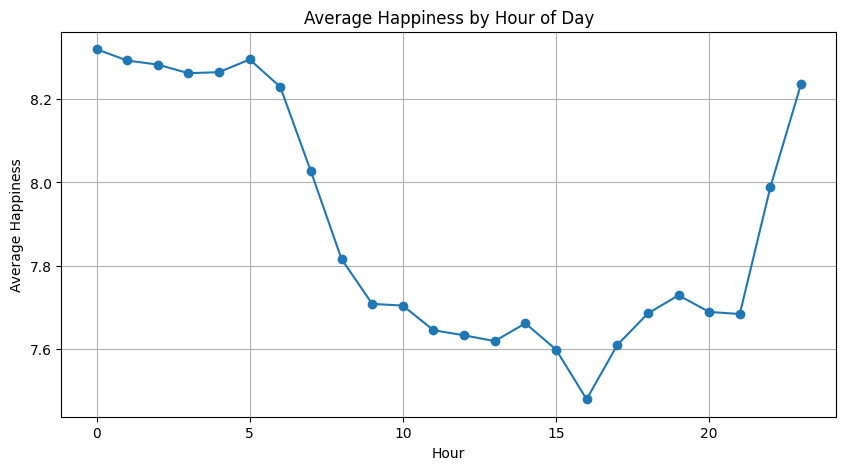

In [34]:
# Extract hour from time if it's datetime
cleaned_data['Hour'] = pd.to_datetime(cleaned_data['Time'], errors='coerce').dt.hour

avg_happy_hour = cleaned_data.groupby('Hour')['Happy'].mean()

plt.figure(figsize=(10,5))
avg_happy_hour.plot(kind='line', marker='o')
plt.title('Average Happiness by Hour of Day')
plt.ylabel('Average Happiness')
plt.xlabel('Hour')
plt.grid(True)
plt.show()


**. Happiness vs. Where**

Where students are happiest — home, park, restaurant, etc.

Bar chart of avg happiness by location (Where).

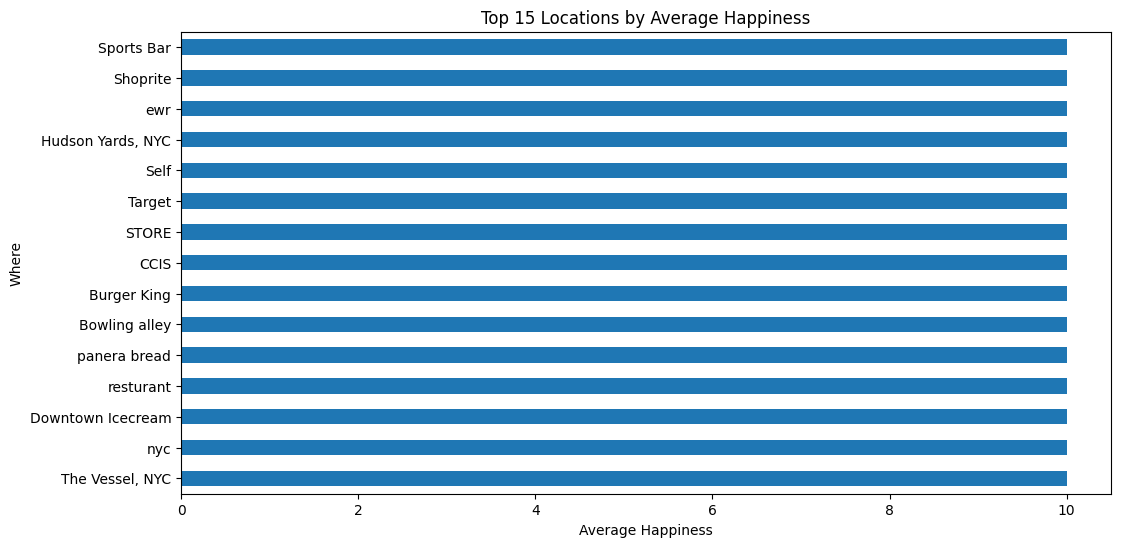

In [35]:
avg_happy_where = cleaned_data.groupby('Where')['Happy'].mean().sort_values(ascending=False).head(15)

plt.figure(figsize=(12,6))
avg_happy_where.plot(kind='barh')
plt.title('Top 15 Locations by Average Happiness')
plt.xlabel('Average Happiness')
plt.gca().invert_yaxis()
plt.show()


**6. Are students early birds or night owls? (Pie Chart)**

Group activity times:

Morning (6am-12pm)

Afternoon (12pm-6pm)

Evening (6pm-12am)

Night (12am-6am)

Pie chart showing what % of activities happen in each slot.

In [36]:
import pandas as pd
import plotly.express as px

# First, make sure 'Hour' column exists
cleaned_data['Hour'] = pd.to_datetime(cleaned_data['Time'], errors='coerce').dt.hour

# Define the function to label time slots
def time_slot(hour):
    if 6 <= hour < 12:
        return 'Morning (6am-12pm)'
    elif 12 <= hour < 18:
        return 'Afternoon (12pm-6pm)'
    elif 18 <= hour < 24:
        return 'Evening (6pm-12am)'
    else:
        return 'Night (12am-6am)'

# Apply the function to create a new column
cleaned_data['Time_Slot'] = cleaned_data['Hour'].apply(time_slot)

# Count the activities in each time slot
time_slot_counts = cleaned_data['Time_Slot'].value_counts().reset_index()
time_slot_counts.columns = ['Time_Slot', 'Activity_Count']

# Plot the pie chart
fig = px.pie(
    time_slot_counts,
    names='Time_Slot',
    values='Activity_Count',
    title="Are Students Early Birds or Night Owls?",
    color_discrete_sequence=px.colors.qualitative.Pastel
)

fig.update_traces(textinfo='percent+label')
fig.show()


C:\Users\tinot\AppData\Local\Temp\ipykernel_35756\4236092237.py:5: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



**Activity WordCloud**

Generate a WordCloud of activities.

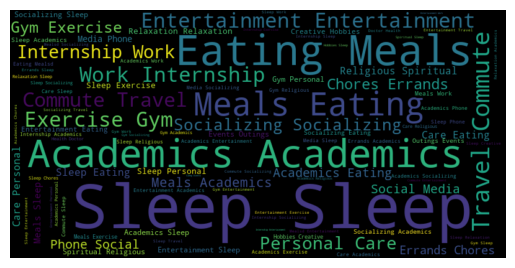

In [37]:
from wordcloud import WordCloud

text = " ".join(cleaned_data['Activity_Cleaned'])
wordcloud = WordCloud(width=800, height=400).generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


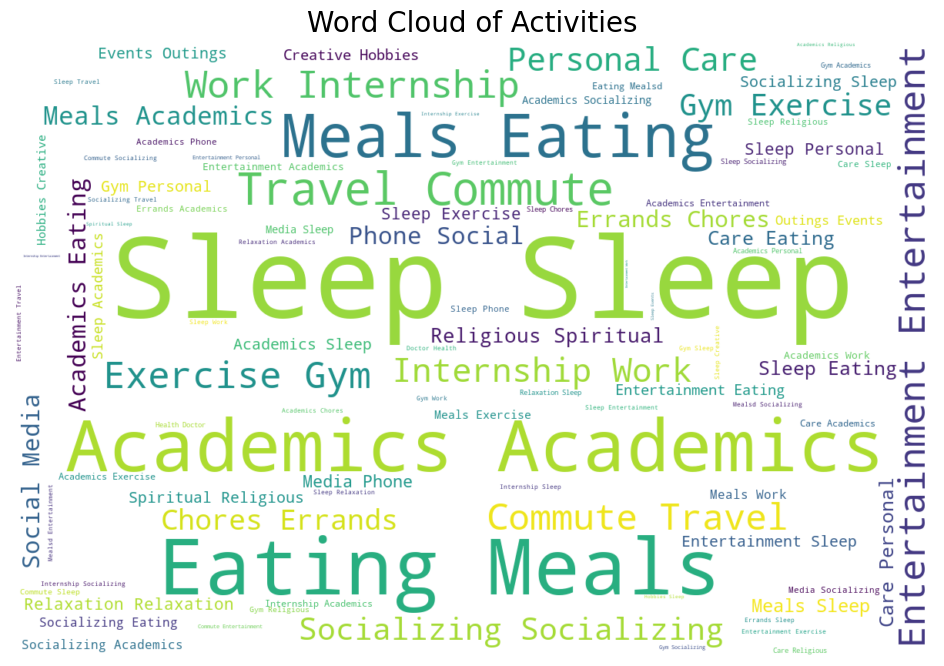

In [38]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = " ".join(cleaned_data['Activity_Cleaned'].dropna())

wordcloud = WordCloud(width=1200, height=800, background_color='white').generate(text)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Activities', fontsize=20)
plt.show()


** Submission Week Comparison**

Do activities or happiness change across Week 1, 2, 3?

Side-by-side bar plots: Happiness Week1 vs Week2 vs Week3

Activities most common in each week.

In [39]:
import plotly.express as px

# Average happiness per week
week_happy = cleaned_data.groupby('Submission_Week')['Happy'].mean().reset_index()

# Sort the weeks properly if needed
week_happy['Submission_Week'] = pd.Categorical(
    week_happy['Submission_Week'], 
    categories=['Week1', 'Week2', 'Week3'],
    ordered=True
)
week_happy = week_happy.sort_values('Submission_Week')

# Plot
fig = px.bar(
    week_happy,
    x='Submission_Week',
    y='Happy',
    text='Happy',
    color='Submission_Week',
    title='Average Happiness Across Submission Weeks',
    color_discrete_sequence=px.colors.qualitative.Pastel
)

fig.update_layout(
    yaxis_title='Average Happiness',
    xaxis_title='Submission Week',
    showlegend=False
)

fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')

fig.show()


**Activities Most Common in Each Week**

In [40]:
# Count top 5 activities per week
top_activities = cleaned_data.groupby(['Submission_Week', 'Activity_Cleaned']).size().reset_index(name='Count')

# Optional: pick top 5 activities across ALL weeks for simpler view
top_activities_list = cleaned_data['Activity_Cleaned'].value_counts().head(5).index.tolist()
top_activities = top_activities[top_activities['Activity_Cleaned'].isin(top_activities_list)]

# Plot
fig = px.bar(
    top_activities,
    x='Activity_Cleaned',
    y='Count',
    color='Submission_Week',
    barmode='group',
    title='Top Activities by Submission Week',
    color_discrete_sequence=px.colors.qualitative.Set2
)

fig.update_layout(
    xaxis_title='Activity',
    yaxis_title='Count of Activities',
)

fig.show()


**Activity Distribution by Period of Day**

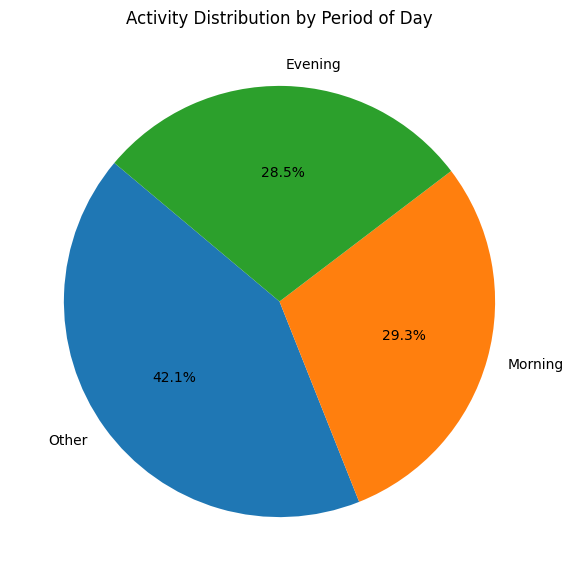

In [41]:
# Define morning as 5am-12pm, evening as 5pm-12am
def day_period(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 17 <= hour <= 23:
        return 'Evening'
    else:
        return 'Other'

cleaned_data['Period'] = cleaned_data['Hour'].apply(day_period)
period_counts = cleaned_data['Period'].value_counts()

plt.figure(figsize=(7,7))
period_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Activity Distribution by Period of Day')
plt.ylabel('')
plt.show()


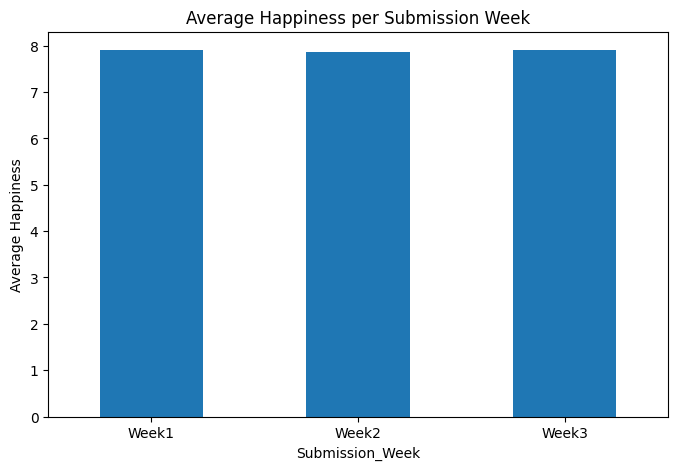

In [42]:
avg_happy_week = cleaned_data.groupby('Submission_Week')['Happy'].mean()

plt.figure(figsize=(8,5))
avg_happy_week.plot(kind='bar')
plt.title('Average Happiness per Submission Week')
plt.ylabel('Average Happiness')
plt.xticks(rotation=0)
plt.show()


**Sunburst Chart (Time → Activity → Who)**

In [43]:
import plotly.express as px

fig = px.sunburst(
    cleaned_data,
    path=['Day', 'Activity_Cleaned', 'Who'],
    values='Happy',
    color='Happy',
    color_continuous_scale='RdBu',
    title='Sunburst of Day → Activity → Who (weighted by Happiness)'
)
fig.show()


**Animated Timeline of Activities (Over Hours)**

In [44]:
fig = px.histogram(
    cleaned_data, 
    x='Hour', 
    color='Activity_Cleaned', 
    animation_frame='Submission_Week',
    nbins=24,
    title='Activity Distribution over Hours (Animated by Week)',
    labels={'Hour': 'Hour of the Day'}
)

fig.show()


**Sankey Diagram (Flow of Activities)**

In [45]:
import plotly.graph_objects as go

# Take first 10 activities for a clean Sankey
sample = cleaned_data[['Activity_Cleaned']].dropna().sample(500)

source_labels = sample['Activity_Cleaned'].values[:-1]
target_labels = sample['Activity_Cleaned'].values[1:]

labels = list(pd.unique(source_labels.tolist() + target_labels.tolist()))
source = [labels.index(src) for src in source_labels]
target = [labels.index(tgt) for tgt in target_labels]

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15, thickness=20, line=dict(color="black", width=0.5),
        label=labels
    ),
    link=dict(
        source=source,
        target=target,
        value=[1]*len(source)
    ))])

fig.update_layout(title_text="Sankey Diagram of Activity Transitions", font_size=10)
fig.show()


C:\Users\tinot\AppData\Local\Temp\ipykernel_35756\1770123120.py:9: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



**Treemap of Activities by Happiness**

In [46]:
fig = px.treemap(
    cleaned_data, 
    path=['Activity_Cleaned'], 
    values='Happy',
    color='Happy',
    color_continuous_scale='Blues',
    title='Treemap of Activities weighted by Happiness'
)
fig.show()


In [ ]:
import plotly.express as px

# Filter for one student
student_id = 4195058507542523904 # ← choose any Student_ID
student_data = cleaned_data[cleaned_data['Student_ID'] == student_id]

# Convert Time to datetime.datetime for plotting
#student_data = student_data.dropna(subset=['Time'])  # drop NaTs
student_data['Datetime'] = pd.to_datetime(student_data['Time'], errors='coerce')

# Plot
fig = px.timeline(
    student_data,
    x_start='Datetime',
    x_end='Datetime',
    y='Day',
    color='Activity_Cleaned',
    title=f'Activity Timeline for Student {student_id}',
    color_discrete_sequence=px.colors.qualitative.Alphabet
)

fig.update_layout(
    xaxis_title='Time of Day',
    yaxis_title='Day',
    yaxis_autorange='reversed',  # Monday on top
)

fig.show()



C:\Users\tinot\AppData\Local\Temp\ipykernel_35756\1996316226.py:9: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

C:\Users\tinot\AppData\Local\Temp\ipykernel_35756\1996316226.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ValueError: Both x_start and x_end are required

**Happiness Trend Across Days for the Student**

In [58]:
import plotly.express as px

# Happiness per Day
happiness_day = student_data.groupby('Day')['Happy'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
).reset_index()

# Plot
fig = px.line(
    happiness_day,
    x='Day',
    y='Happy',
    markers=True,
    title=f'Happiness Trend for Student {student_id}',
    line_shape='spline',
    color_discrete_sequence=['royalblue']
)

fig.update_layout(
    yaxis_title='Average Happiness',
    xaxis_title='Day of Week',
)

fig.show()


**Wordcloud of Student's Activities**

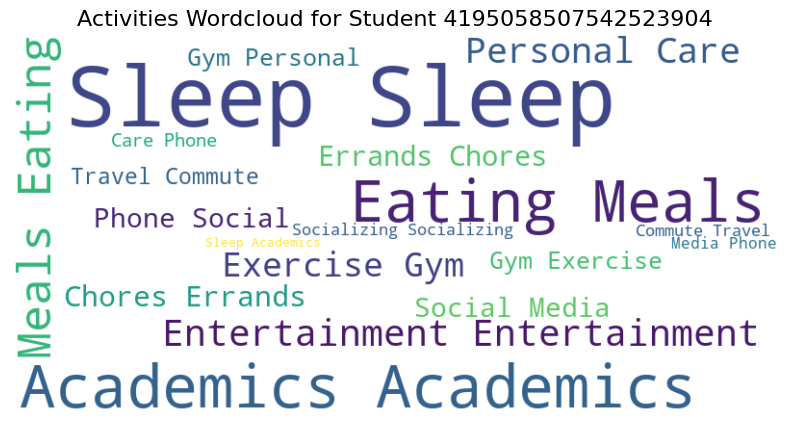

In [59]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Join all activities
text = ' '.join(student_data['Activity_Cleaned'].dropna())

# Generate WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f'Activities Wordcloud for Student {student_id}', fontsize=16)
plt.show()


In [56]:
cleaned_data['Student_ID'].unique()

array([4195058507542523904, 2864065836498320384, 3831822015793650688,
       3192327372956697600, 3539819342817507328, 3539122736994684928,
        856416271322893952, 4811270876540148736, 9110248306741498880,
       5492887458645880832, 2718578593585804800, 3135418365228227072,
       7766294401165046784, 5324089783292767232, 5950349526882352128,
       6842421863231194112,  688813731993989632, 7191910724967089152,
       7520525085606131712, 1475472374561650176,  322255158917228160,
       4254566427575334400, 6445721957429367808, 4447610051912183296,
       1731811686631885568, 6207547687900069888, 9088114324560681984,
        347534785502028608, 6146037901327582208, 3015292668143311872,
       2440039937083765760, 7766761966966132736, 7231582939658241024,
        795931821777314688, 8141111804729216000, 1015744811505133568,
       2341855106665279488, 2777710331735021568,   30871839097760468,
       5034955734851379200, 3594803656339155456, 2146681369213847552,
       2533607486860

In [ ]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import dash
from dash import dcc, html, Output, Input
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import base64
from io import BytesIO

# --- Load and prepare data ---
cleaned_data = pd.read_csv('schedules_cleaned.csv')

# Fix Time handling
cleaned_data = cleaned_data.dropna(subset=['Time'])
# Convert to datetime and extract hour directly for later use
cleaned_data['Time_DT'] = pd.to_datetime(cleaned_data['Time'], format='%H:%M:%S', errors='coerce')
cleaned_data['Hour'] = cleaned_data['Time_DT'].dt.hour
cleaned_data['Time'] = cleaned_data['Time_DT'].dt.time

# Calculate the average student activity pattern for comparison
avg_activity_hours = cleaned_data.groupby('Hour')['Activity_Cleaned'].count().reset_index()
avg_activity_hours['Avg_Count'] = avg_activity_hours['Activity_Cleaned'] / cleaned_data['Student_ID'].nunique()
avg_activity_hours = avg_activity_hours[['Hour', 'Avg_Count']]

# Create Dash App
app = dash.Dash(__name__, suppress_callback_exceptions=True)

# Layout
app.layout = html.Div([
    html.H1('Student Activity Dashboard', style={'textAlign': 'center', 'color': '#2c3e50', 'marginBottom': '30px'}),
    
    html.Div([
        dcc.Dropdown(
            id='student-dropdown',
            options=[{'label': str(sid), 'value': sid} for sid in cleaned_data['Student_ID'].unique()],
            placeholder='Select a Student ID',
            style={'width': '40%', 'display': 'inline-block', 'marginRight': '10px'}
        ),
        dcc.Dropdown(
            id='week-dropdown',
            options=[{'label': wk, 'value': wk} for wk in sorted(cleaned_data['Submission_Week'].unique())],
            placeholder='Select a Submission Week',
            style={'width': '30%', 'display': 'inline-block'}
        )
    ], style={'textAlign': 'center', 'padding': '20px', 'backgroundColor': '#f8f9fa', 'borderRadius': '10px'}),
    
    html.Div([
        html.Div([
            dcc.Graph(id='timeline-plot')
        ], style={'width': '60%'}),
        html.Div([
            dcc.Graph(id='activity-dist')
        ], style={'width': '40%'})
    ], style={'display': 'flex', 'gap': '20px', 'padding': '20px'}),
    
    html.Div([
        html.Div([
            dcc.Graph(id='happiness-plot')
        ], style={'width': '50%'}),
        html.Div([
            dcc.Graph(id='happiness-by-activity')
        ], style={'width': '50%'})
    ], style={'display': 'flex', 'gap': '20px', 'padding': '20px'}),
    
    html.Div([
        html.Div([
            dcc.Graph(id='active-hours-plot')
        ], style={'width': '50%'}),
        html.Div([
            dcc.Graph(id='comparison-plot')
        ], style={'width': '50%'})
    ], style={'display': 'flex', 'gap': '20px', 'padding': '20px'}),
    
    html.Div([
        html.Img(id='wordcloud', style={'height': '400px', 'margin': 'auto'})
    ], style={'textAlign': 'center', 'padding': '20px', 'backgroundColor': '#f8f9fa', 'borderRadius': '10px'})
])

# Callbacks
@app.callback(
    [Output('timeline-plot', 'figure'),
     Output('activity-dist', 'figure'),
     Output('happiness-plot', 'figure'),
     Output('happiness-by-activity', 'figure'),
     Output('active-hours-plot', 'figure'),
     Output('comparison-plot', 'figure'),
     Output('wordcloud', 'src')],
    [Input('student-dropdown', 'value'),
     Input('week-dropdown', 'value')]
)
def update_dashboard(student_id, week):
    # FIXED: Create empty figures using plotly.graph_objects instead of px
    # This avoids the TypeError with empty histograms
    empty_message = "No data selected. Please select a Student ID and Week."
    
    # Create empty figures with proper message
    def create_empty_figure(title=empty_message):
        return go.Figure().update_layout(
            title=title,
            xaxis={"visible": False},
            yaxis={"visible": False},
            annotations=[{
                "text": title,
                "xref": "paper",
                "yref": "paper",
                "showarrow": False,
                "font": {"size": 20}
            }]
        )
    
    # Empty figure set
    empty_fig = create_empty_figure()
    empty_pie = create_empty_figure()
    empty_line = create_empty_figure()
    empty_bar = create_empty_figure()
    empty_hist = create_empty_figure()
    
    if student_id is None or week is None:
        # Return empty figures with proper structures to avoid errors
        return empty_fig, empty_pie, empty_line, empty_bar, empty_hist, empty_line, ''

    # Ensure we're matching the correct types when filtering
    try:
        student_id = int(student_id)
    except (ValueError, TypeError):
        # If conversion fails, use as is
        pass
    
    student_data = cleaned_data[(cleaned_data['Student_ID'] == student_id) & (cleaned_data['Submission_Week'] == week)]

    if student_data.empty:
        no_data_message = f"No data available for Student {student_id}, Week {week}"
        empty_fig = create_empty_figure(no_data_message)
        empty_pie = create_empty_figure(no_data_message)
        empty_line = create_empty_figure(no_data_message)
        empty_bar = create_empty_figure(no_data_message)
        empty_hist = create_empty_figure(no_data_message)
        return empty_fig, empty_pie, empty_line, empty_bar, empty_hist, empty_line, ''

    # 1. Timeline Plot
    timeline_fig = px.scatter(
        student_data,
        x='Time',
        y='Day',
        color='Activity_Cleaned',
        title=f'Activity Timeline - Student {student_id}, Week {week}',
        color_discrete_sequence=px.colors.qualitative.Alphabet
    )
    timeline_fig.update_layout(
        xaxis=dict(title='Time of Day'),
        yaxis=dict(autorange='reversed', title='Day of Week'),
        height=500,
        legend_title="Activity"
    )
    
    # 2. Activity Distribution
    activity_dist = px.pie(
        student_data, 
        names='Activity_Cleaned', 
        title=f'Activity Distribution - Student {student_id}, Week {week}',
        hole=0.3,  # Donut chart style
        color_discrete_sequence=px.colors.qualitative.Alphabet
    )
    activity_dist.update_traces(textposition='inside', textinfo='percent+label')
    activity_dist.update_layout(height=500, legend_title="Activity")

    # 3. Happiness Plot - with day order fixed
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    happiness_day = student_data.groupby('Day')['Happy'].mean().reset_index()
    
    # Fixed: Better handling of day ordering
    happiness_day['Day'] = pd.Categorical(happiness_day['Day'], categories=day_order, ordered=True)
    happiness_day = happiness_day.sort_values('Day')
    
    happiness_fig = px.line(
        happiness_day,
        x='Happy',
        y='Day',
        markers=True,
        title=f'Happiness Over Days - Student {student_id}, Week {week}',
        line_shape='linear',  # Changed from spline for more accurate representation
        color_discrete_sequence=['royalblue']
    )
    happiness_fig.update_layout(
        yaxis_title='Avg Happiness Score',
        xaxis_title='Day of Week',
        yaxis=dict(range=[0, 10]),
        height=500
    )
    
    # 4. Happiness by Activity
    happiness_by_activity = px.bar(
        student_data.groupby('Activity_Cleaned')['Happy'].mean().reset_index().sort_values('Happy', ascending=False),
        x='Activity_Cleaned', 
        y='Happy',
        title=f'Average Happiness by Activity - Student {student_id}, Week {week}',
        color='Happy',
        color_continuous_scale='RdYlGn'  # Red to yellow to green color scale
    )
    happiness_by_activity.update_layout(
        height=500, 
        xaxis_title='Activity', 
        yaxis_title='Avg Happiness Score', 
        xaxis={'categoryorder':'total descending'},
        yaxis=dict(range=[0, 10])
    )
    # Rotate x-axis labels for better readability
    happiness_by_activity.update_xaxes(tickangle=45)

    # 5. Active Hours Plot
    active_hours_fig = px.histogram(
        student_data,
        x='Hour',
        nbins=24,
        range_x=[0, 23.5],  # Fixed range to ensure all 24 hours are shown
        labels={'Hour': 'Hour of Day', 'y': 'Activity Count'},
        title=f'Most Active Hours - Student {student_id}, Week {week}',
        color_discrete_sequence=['orange']
    )
    active_hours_fig.update_layout(
        xaxis=dict(dtick=1, title="Hour of Day"),
        yaxis=dict(title="Activity Count"),
        height=500
    )
    
    # 6. Comparison with Average Plot
    # Calculate hourly activity counts for this student
    student_hours = student_data.groupby('Hour').size().reset_index(name='Count')
    
    # Create a DataFrame with all hours from 0-23
    all_hours = pd.DataFrame({'Hour': range(24)})
    
    # Merge with student data and fill missing hours with 0
    student_hours = all_hours.merge(student_hours, on='Hour', how='left').fillna(0)
    
    # Merge with average data
    student_hours = student_hours.merge(avg_activity_hours, on='Hour', how='left').fillna(0)
    
    # Fixed: Correctly rename the metric for the plot
    student_hours_long = pd.melt(
        student_hours, 
        id_vars=['Hour'], 
        value_vars=['Count', 'Avg_Count'],
        var_name='Metric', 
        value_name='Value'
    )
    
    # Fixed: Correct the replacement for 'Avg_Count'
    student_hours_long['Metric'] = student_hours_long['Metric'].replace({
        'Count': 'This Student', 
        'Avg_Count': 'Average Student'
    })
    
    comparison_fig = px.line(
        student_hours_long,
        x='Hour', 
        y='Value',
        color='Metric',
        title=f'Student vs Average Activity Pattern - Student {student_id}, Week {week}',
        labels={'Value': 'Activity Count', 'Hour': 'Hour of Day', 'Metric': 'Activity Pattern'},
        color_discrete_sequence=['#1f77b4', '#ff7f0e']
    )
    comparison_fig.update_layout(
        height=500, 
        xaxis=dict(dtick=1, range=[0, 23])
    )

    # 7. WordCloud
    text = ' '.join(student_data['Activity_Cleaned'].dropna())
    if not text.strip():  # Handle empty text
        text = "No activities recorded"
    
    try:
        wordcloud = WordCloud(
            width=600, 
            height=400, 
            background_color='white', 
            colormap='viridis', 
            max_words=100,
            collocations=False  # Avoid repeated word pairs
        ).generate(text)
        
        img = BytesIO()
        plt.figure(figsize=(10, 7))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Activity WordCloud - Student {student_id}, Week {week}')
        plt.tight_layout(pad=0)
        plt.savefig(img, format='PNG', bbox_inches='tight')
        plt.close()
        img.seek(0)
        encoded = base64.b64encode(img.read()).decode('ascii')
        wordcloud_src = f'data:image/png;base64,{encoded}'
    except Exception as e:
        print(f"Error generating wordcloud: {e}")
        # Return a blank image if wordcloud fails
        wordcloud_src = ''

    return timeline_fig, activity_dist, happiness_fig, happiness_by_activity, active_hours_fig, comparison_fig, wordcloud_src

# Run
if __name__ == '__main__':
    app.run(debug=True)

In [ ]:
cleaned_data.head()

,Student_ID,Day,Submission_Week,Time,Activity,Who,Where,Happy,Activity_Cleaned
0,4195058507542523866,Monday,Week1,00:00:00,Sleep,Self,Home,7,Sleep
1,4195058507542523866,Monday,Week1,00:30:00,Sleep,Self,Home,7,Sleep
2,4195058507542523866,Monday,Week1,01:00:00,Sleep,Self,Home,7,Sleep
3,4195058507542523866,Monday,Week1,01:30:00,Sleep,Self,Home,7,Sleep
4,4195058507542523866,Monday,Week1,02:00:00,Sleep,Self,Home,7,Sleep


In [ ]:
# Let's inspect the DataFrame structure and contents
print("DataFrame shape:", cleaned_data.shape)
print("\nColumns:", cleaned_data.columns.tolist())
print("\nData types:")
print(cleaned_data.dtypes)
print("\nFirst 5 rows:")
cleaned_data.head()


DataFrame shape: (67425, 11)

Columns: ['Student_ID', 'Day', 'Submission_Week', 'Time', 'Activity', 'Who', 'Where', 'Happy', 'Activity_Cleaned', 'Time_DT', 'Hour']

Data types:
Student_ID                   int64
Day                         object
Submission_Week             object
Time                        object
Activity                    object
Who                         object
Where                       object
Happy                        int64
Activity_Cleaned            object
Time_DT             datetime64[ns]
Hour                         int32
dtype: object

First 5 rows:


,Student_ID,Day,Submission_Week,Time,Activity,Who,Where,Happy,Activity_Cleaned,Time_DT,Hour
0,4195058507542523866,Monday,Week1,00:00:00,Sleep,Self,Home,7,Sleep,1900-01-01 00:00:00,0
1,4195058507542523866,Monday,Week1,00:30:00,Sleep,Self,Home,7,Sleep,1900-01-01 00:30:00,0
2,4195058507542523866,Monday,Week1,01:00:00,Sleep,Self,Home,7,Sleep,1900-01-01 01:00:00,1
3,4195058507542523866,Monday,Week1,01:30:00,Sleep,Self,Home,7,Sleep,1900-01-01 01:30:00,1
4,4195058507542523866,Monday,Week1,02:00:00,Sleep,Self,Home,7,Sleep,1900-01-01 02:00:00,2


In [ ]:
# Check for missing values
print("\nMissing values per column:")
print(cleaned_data.isna().sum())


Missing values per column:
Student_ID          0
Day                 0
Submission_Week     0
Time                0
Activity            0
Who                 0
Where               0
Happy               0
Activity_Cleaned    0
Time_DT             0
Hour                0
dtype: int64


In [ ]:
# Unique values in categorical columns
print("\nUnique Student_IDs:", cleaned_data['Student_ID'].nunique())
print("Unique Submission Weeks:", cleaned_data['Submission_Week'].nunique())
print("Activity types:", cleaned_data['Activity_Cleaned'].nunique())
print("Days of week:", cleaned_data['Day'].unique())


Unique Student_IDs: 68
Unique Submission Weeks: 3
Activity types: 18
Days of week: ['Monday' 'Tuesday' 'Wednesday' 'Thursday' 'Friday' 'Saturday' 'Sunday']
